In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.imports import *
from fastai.transforms import *
from fastai.plots import *
from fastai.structured import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
if torch.cuda.is_available():
    display("Cuda enabled")
    torch.cuda.set_device(0)
else:
    display("Cuda not enabled")

'Cuda not enabled'

## Preprocessing: Data Augmentation

We're going to be using a subset fo the [Google Maps Dataset](http://crcv.ucf.edu/data/GMCP_Geolocalization/) to train our model

In [4]:
PATH = Path('data/')
RAW_IMAGES = PATH/'raw'
TRAIN_IMAGES = PATH/'train/images'
TRAIN_CSV = PATH/'train/rotation.csv'

In [5]:
# Source: https://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders

def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """

    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

In [ ]:
def gen_rand_file_name():
    return ''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(15)) + '.jpg'

In [ ]:
train_files = glob(str(TRAIN_IMAGES) + '/*')
for f in train_files:
    os.remove(f)

In [ ]:
img_files = os.listdir(RAW_IMAGES)

MAX_ROTATION_ABS = 45 # rotate no more than 45 degrees
NUM_AUGMENTATIONS = 1
IMAGE_SIZE = 224
name_to_rotation = {}

total = 0

print(f'Processing {len(img_files)} images.')
for img_file in img_files:
    if total % 200 == 0:
        print(f'{total} processed.')
    for i in range(NUM_AUGMENTATIONS):
        rotation_deg =  (random.random() * MAX_ROTATION_ABS * 2) - MAX_ROTATION_ABS

        img = plt.imread(RAW_IMAGES/img_file)
        img = Image.fromarray(img)
        img = img.resize((IMAGE_SIZE*2, IMAGE_SIZE*2))
        img = np.array(img)
        
        image_height, image_width = img.shape[0:2]

        new_image = rotate_image(img, rotation_deg)
        new_image = crop_around_center(
            new_image,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(rotation_deg)
            )
        )
        file_name = gen_rand_file_name()
        
        save_image = Image.fromarray(new_image)
        save_image = save_image.resize((IMAGE_SIZE, IMAGE_SIZE))
        save_image.save(TRAIN_IMAGES/file_name)
        
        name_to_rotation[file_name] = -rotation_deg
    total += 1


In [ ]:
dataframe = pd.DataFrame.from_dict(
    name_to_rotation,
    orient='index',
)
dataframe = dataframe.reset_index()
dataframe.columns = ['filename', 'rotation']
dataframe = dataframe.set_index('filename')
dataframe.to_csv(TRAIN_CSV)
dataframe = dataframe.reset_index()

In [ ]:
dataframe.head()

In [ ]:
test_image = plt.imread(TRAIN_IMAGES/dataframe.filename[100])
display(plt.imshow(test_image))
display(dataframe.rotation[100])

In [ ]:
plt.imshow(rotate_image(test_image, dataframe.rotation[100]))

## Setup Training

In [33]:
dataframe = pd.read_csv(TRAIN_CSV)
dataframe.head()

,filename,rotation
0,4y7kac6742mky22.jpg,23.575932
1,3ud4ac2t0evjrgi.jpg,21.143114
2,d0gbpjnv7bf8t8a.jpg,-27.459901
3,u0ildkh21shyvgh.jpg,5.278535
4,rkuemjm5curcr2q.jpg,-32.859624


In [34]:
training_mask = np.random.rand(len(dataframe)) < .9

In [35]:
train = dataframe[training_mask].reset_index()
validation = dataframe[~training_mask].reset_index()

In [36]:
class RotationDataset(Dataset):
    def __init__(self, dataframe):
        self.file_names = dataframe.filename
        self.rotations = dataframe.rotation
        
    def __len__(self): return len(self.file_names)
    
    def __getitem__(self, i):
        file_name, y = self.file_names[i], self.rotations[i]
        image_data = plt.imread(TRAIN_IMAGES/file_name).astype('int16')
        return image_data, y

In [37]:
train_dataset = RotationDataset(dataframe)
val_dataset = RotationDataset(dataframe)

In [38]:
arch = resnet34
sz = 224
bs = 64
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO)
# md = ImageClassifierData.from_csv(
#     path=PATH,
#     folder='train/images', 
#     csv_fname=TRAIN_CSV,
#     bs=bs,
#     tfms=tfms
# )
md = ModelData.from_dls(
    path=PATH,
    trn_dl = DataLoader(
        dataset=train_dataset,
        batch_size=bs,
    ),
    val_dl = DataLoader(
        dataset=val_dataset,
        batch_size=bs
    )
)

In [39]:
x,y = next(iter(md.trn_dl))

In [40]:
x.shape

torch.Size([64, 224, 224, 3])

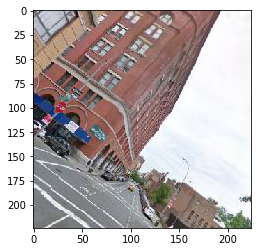

In [44]:
plt.imshow(to_np(x[60]))

In [45]:
y[60]

37.673831939697266

In [46]:
fixed = to_np(x[60]).astype(np.uint8)

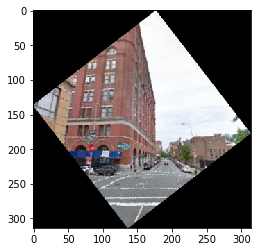

In [47]:
plt.imshow(rotate_image(fixed, 37.67))